![📷 Dettifoss, Island](island.jpg){fig-align="center" width="90%"}

# Hydrologiprosjekt i Geofag 1

Her kjem eit døme på korleis ein kan bruka og behandla nokre av dei store hydrologi-datamengdene me har tilgjengeleg i Noreg. Datamaterialet er samla inn av [NVE](https://www.nve.no/) og henta frå [Sildre](https://sildre.nve.no/). 

📌 I det følgjande dømet nyttar eg vassføringsdata frå [Reinsnosvatn](https://www.norgeskart.no/#!?project=norgeskart&layers=1002&zoom=11&lat=6674836.62&lon=34802.80&sok=Reinsnosvatn&markerLat=6675824.352100712&markerLon=36873.4684766499&p=searchOptionsPanel)

> Målestasjonen ligger i Ullensvang i Vestland og er aktiv. Den har vært i drift siden juni 1917 og leverer i dag 3 forskjellige målinger. (sildre.nve.no)

Prosjektet tek altså utgangspunkt i daglege målingar frå 1917! 

::: {.callout-tip collapse="true"}
## Tips til nedlasting

1️⃣ Finn deg ei elv på [sildre.nve.no](https://sildre.nve.no) <br>
2️⃣ Trykk på `last ned som csv` <br>
3️⃣ Kryss av på aktuelle instillingar <br>
4️⃣ Last ned

![⬇️ Laste ned data](laste_ned.jpg){fig-align="center"}

:::


## Importere bibliotek

Vassføringsdataa er lasta ned i csv-format. Me bruker `pandas` for å jobba med dette effektivt. I tillegg vert det litt plotting og matematikk, så me treng `pyplot` og `numpy` i tillegg. 


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Opprette dataramme

CSV-fila med vassføringsdata les me inn i ei `dataramme` (*dataframe*). Viss ein tar ein kikk på fila ser ein at det er brukt semikolon for å skilja verdiane, det er to rader før verdiane kjem. Me lagar litt forenkla namn på kolonnene, og les inn data. I tillegg er det nytta komma (og ikkje punktum) som desimalteikn. 

![🔍 Dei første linjene](df.jpg){fig-align="center"}

In [22]:
df = pd.read_csv(
    "vassforing_reinsnos_dogn.csv", 
    sep = ";", 
    skiprows = 2, 
    names = ["dato", "Vassføring", "Korrigert", "Kontrollert"], 
    parse_dates = True, 
    decimal=","
)

df.index = pd.to_datetime(df['dato']) 
df.index = pd.to_datetime(df.index.date)
df = df.drop(columns = ["dato", "Korrigert", "Kontrollert"])

Sjekkar dei nyaste fem målingane i tabellen for å sjå at alt ser ok ut. 

In [23]:
df.tail()

,Vassføring
2023-01-24,1.299365
2023-01-25,1.593457
2023-01-26,2.128418
2023-01-27,2.322153
2023-01-28,2.324195


I tillegg kan me prøva å plotta verdiane i dataramma. <br>
*Har med `;` for å unngå å visa meldinga `<AxesSubplot: >`*

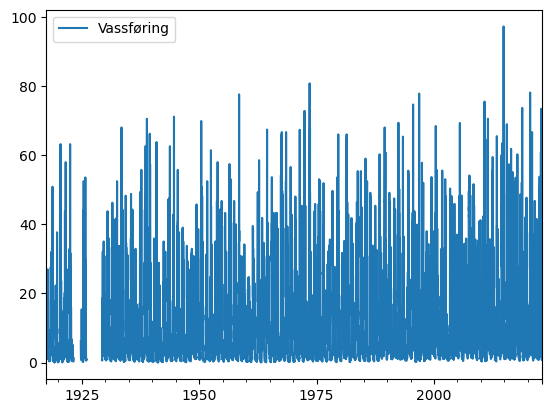

In [24]:
#| fig-align: center
df.plot();

Me ser her at dette ikkje er spesielt nyttig eller informativt, men grafen viser oss at det på 1920-talet er eit par år utan målingar. Korleis dette kan fiksast kjem me attende til litt seinare. 

## Middelflom

Middelflommen til ei elv er rekna ut frå den største døgnvassføringa per år over eit lengre tidsrom. Frå [NVE/varsom.no](https://varsom.no/flom-og-jordskred/ordliste/ordliste-for-flom/) finn me denne definisjonen:

> En middelflom (normal flom) defineres som gjennomsnittet av høyeste vannføring hvert år i en lang årrekke.

For å rekna ut dette må me altså først finna den maksimale vassføringa per år. Bruker `groupby` i Pandas for å finne dette.

In [25]:
årleg_vf_maks = df.groupby(by=[df.index.year]).max()
årleg_vf_maks.head()

,Vassføring
1917,26.98031
1918,50.93218
1919,37.72713
1920,63.26006
1921,58.04514


Plottar den nye dataramma `årleg_maks` som kun har ei måling per år:

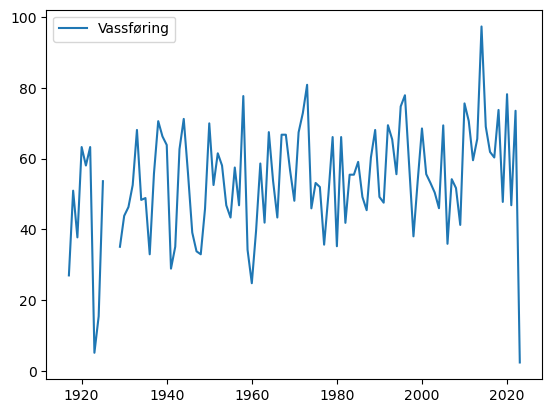

In [26]:
#| fig-align: center
årleg_vf_maks.plot();

På grunn av "holet" i målingane tar me berre med data frå 1930 eller seinare med oss vidare. I tillegg er det vinter (og snø/is) for dataa me har for 2023, så me avgrensar til 2022. 

In [27]:
årleg_vf_maks = årleg_vf_maks.loc[1930:2022]
årleg_vf_maks.head()

,Vassføring
1930,43.82251
1931,46.29647
1932,52.52979
1933,68.09634
1934,48.32775


Me vil finna gjennomsnittleg største årlege vassføring over fleire år. Vel her å sjå på eit gjennomsnitt på 30 år om gongen. Bruker funksjonen `rolling` og `mean` i kombinasjon. `rolling` gjer at me kan gå gjennom dataramma og sjå på dei 30 tidlegare verdiane til kvar rad i tabellen og finna gjennomsnittet (`mean`) i dette rullande vinduet.

In [28]:
maksvf_og_middelflom = årleg_vf_maks.copy()
maksvf_og_middelflom["Middelflom"] = årleg_vf_maks.rolling(window = 30).mean()

Ser på dei første 5 radene

In [29]:
maksvf_og_middelflom.head()

,Vassføring,Middelflom
1930,43.82251,NaN
1931,46.29647,NaN
1932,52.52979,NaN
1933,68.09634,NaN
1934,48.32775,NaN


Ser at dei fem første radene i den nye dataramma er `NaN` (not a number). Dette skjer fordi ein ikkje kan ta gjennomsnitt av dei siste 30 åra før det har gått 30 år... Sjekkar dei nyaste radene i staden:

In [30]:
maksvf_og_middelflom.tail()

,Vassføring,Middelflom
2018,73.75180,60.571163
2019,47.75206,59.893282
2020,78.19958,60.860965
2021,46.81937,60.837067
2022,73.51824,60.972971


Plottar dataramma og ser korleis dei nye verdiane ser ut:

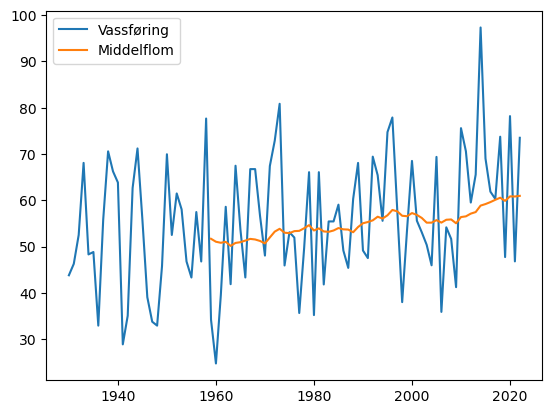

In [31]:
#| fig-align: center
maksvf_og_middelflom.plot();

## Modellering av middelflom

Ser at trenden er oppadgåande og relativt lineær. Ønsker å laga ein lineær modell. Bruker `polyfit` frå `NumPy`. 

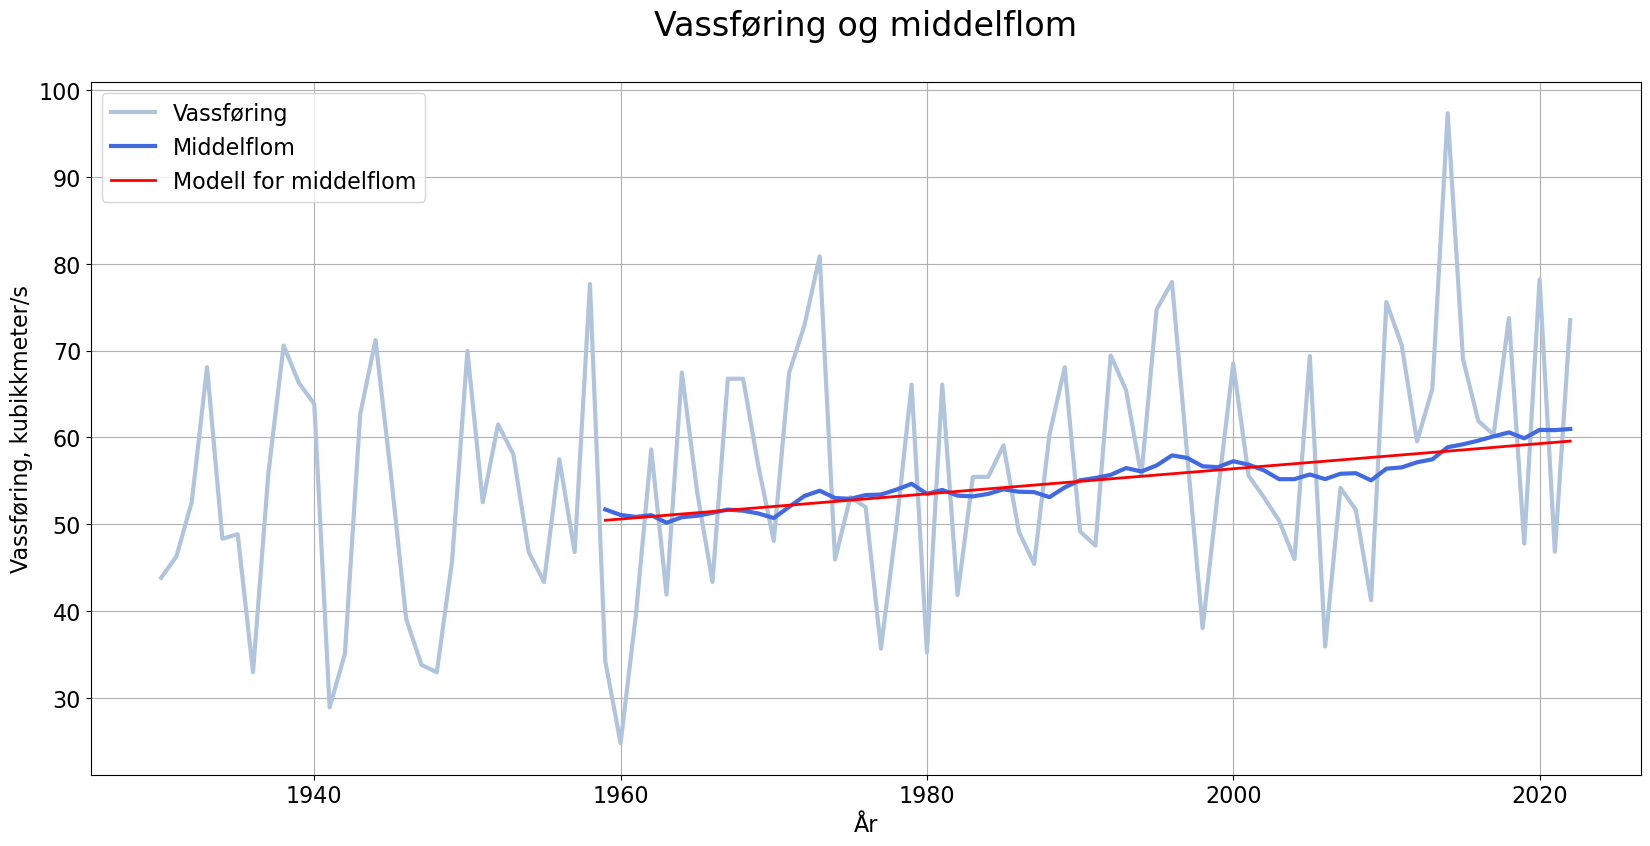

In [32]:
#| fig-align: center
# åra me har data på middelflom
# frå og med 1959 til men ikkje med 2023
x = np.arange(1959, 2023) 

# finn koeffesientane til førstegradspolynomet
a, b = np.polyfit(x, maksvf_og_middelflom["Middelflom"].loc[1959:2022], 1)

# definerer lineær funksjon
def f(x):
    return a*x + b

# plottar dataramma
maksvf_og_middelflom.plot(
    figsize = (20,9), 
    grid = True, 
    fontsize = 16, 
    linewidth = 3, 
    color = ["lightsteelblue", "royalblue"]
)

# plottar modellen
plt.plot(
    x, f(x), 
    linewidth = 2, 
    label = "Modell for middelflom", 
    color = "red"
)

# pynting av plot
plt.title("Vassføring og middelflom\n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
#plt.savefig("Reinsnos - årleg maksvassføring og middelflom.png", dpi = 300)
plt.show()

**Ekstrapolasjon - modell for framtidig middelflom**

Me kan bruka trendlinja for middelflommen som modell for å seie noko om korleis utviklinga vil vera i åra framover (om utviklinga held fram som no): 

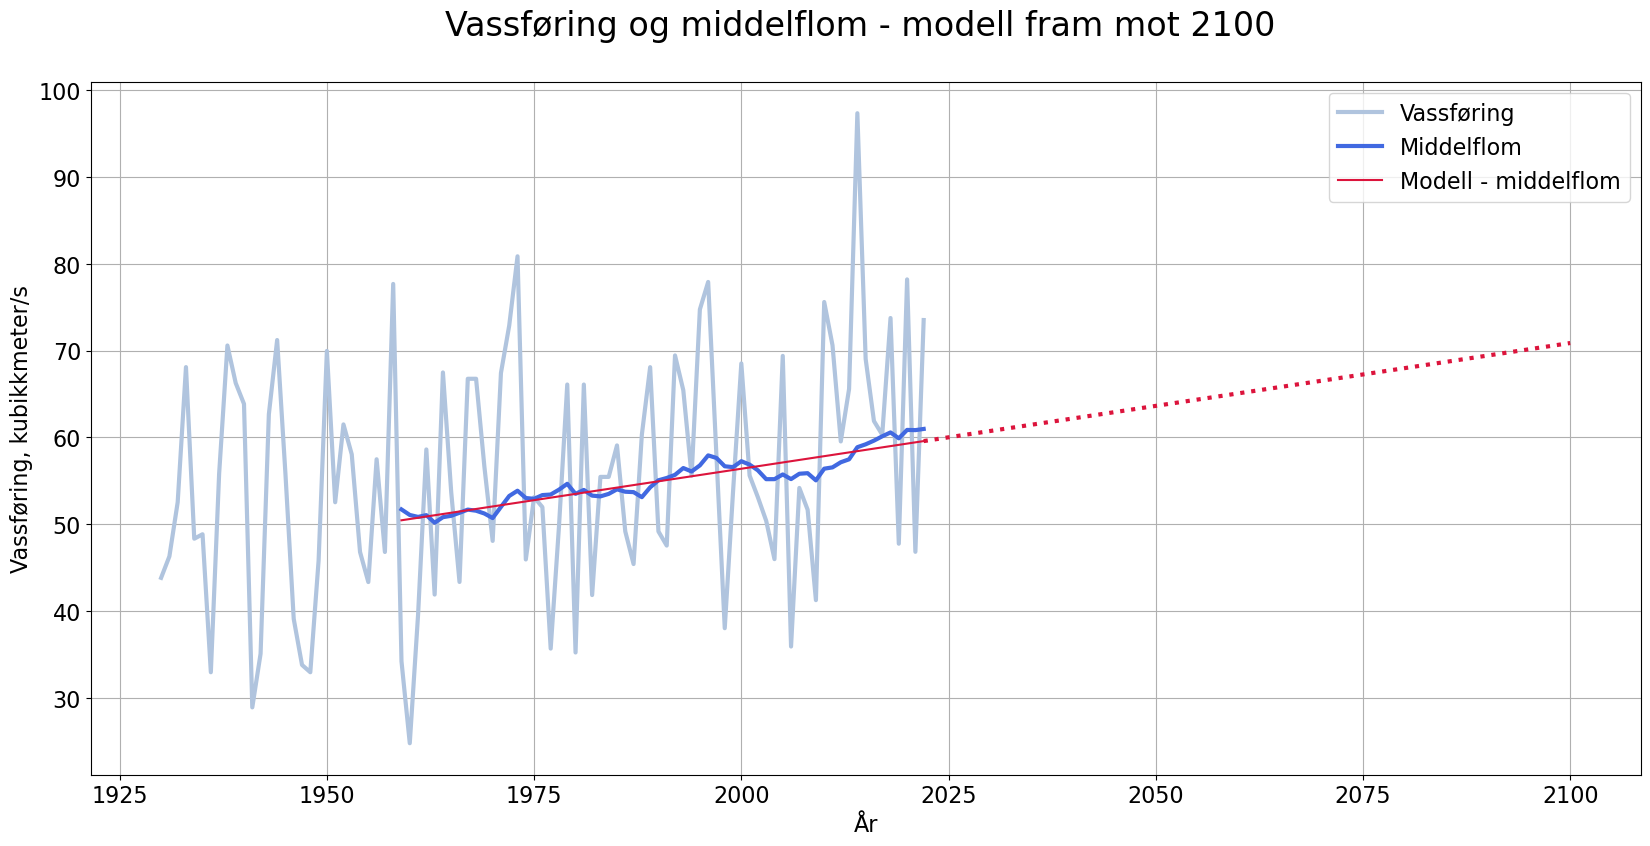

In [33]:
#| code-fold: true
#| fig-align: center
maksvf_og_middelflom.plot(figsize = (20,9), 
                grid = True, 
                fontsize = 16, 
                linewidth = 3, 
                color = ["lightsteelblue", "royalblue"]
               )

plt.plot(x, f(x), 
         linewidth = 1.5, 
         label = "Modell - middelflom", 
         color = "crimson"
        )

# Plottar forlenginga av den lineære modellen
x2 = np.arange(2022, 2101)
plt.plot(x2, f(x2), ":", linewidth = 3, color = "crimson")

# pynting av plot
plt.title("Vassføring og middelflom - modell fram mot 2100 \n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
#plt.savefig("Reinsnos - modellering av middelflom 2100.png", dpi = 300)
plt.show()

## Sjekkar opp mot NVE sine flom-data

Frå stasjonsssida til Reinsnosvatn kan me finna data om ulike typar flom.

![Flomdata frå [NVE](https://sildre.nve.no/station/48.5.0?48.5.0_tab=2)](flomdata_nve.jpg){fig-align="center"}

Ser at verdien for 20-årsflom er 78,28 $m^3/s$.
Plottar inn linja $y=78,28$ i samme figur som tidlegare. Bruker `plt.axhline()` for å teikna horisontal linje. 

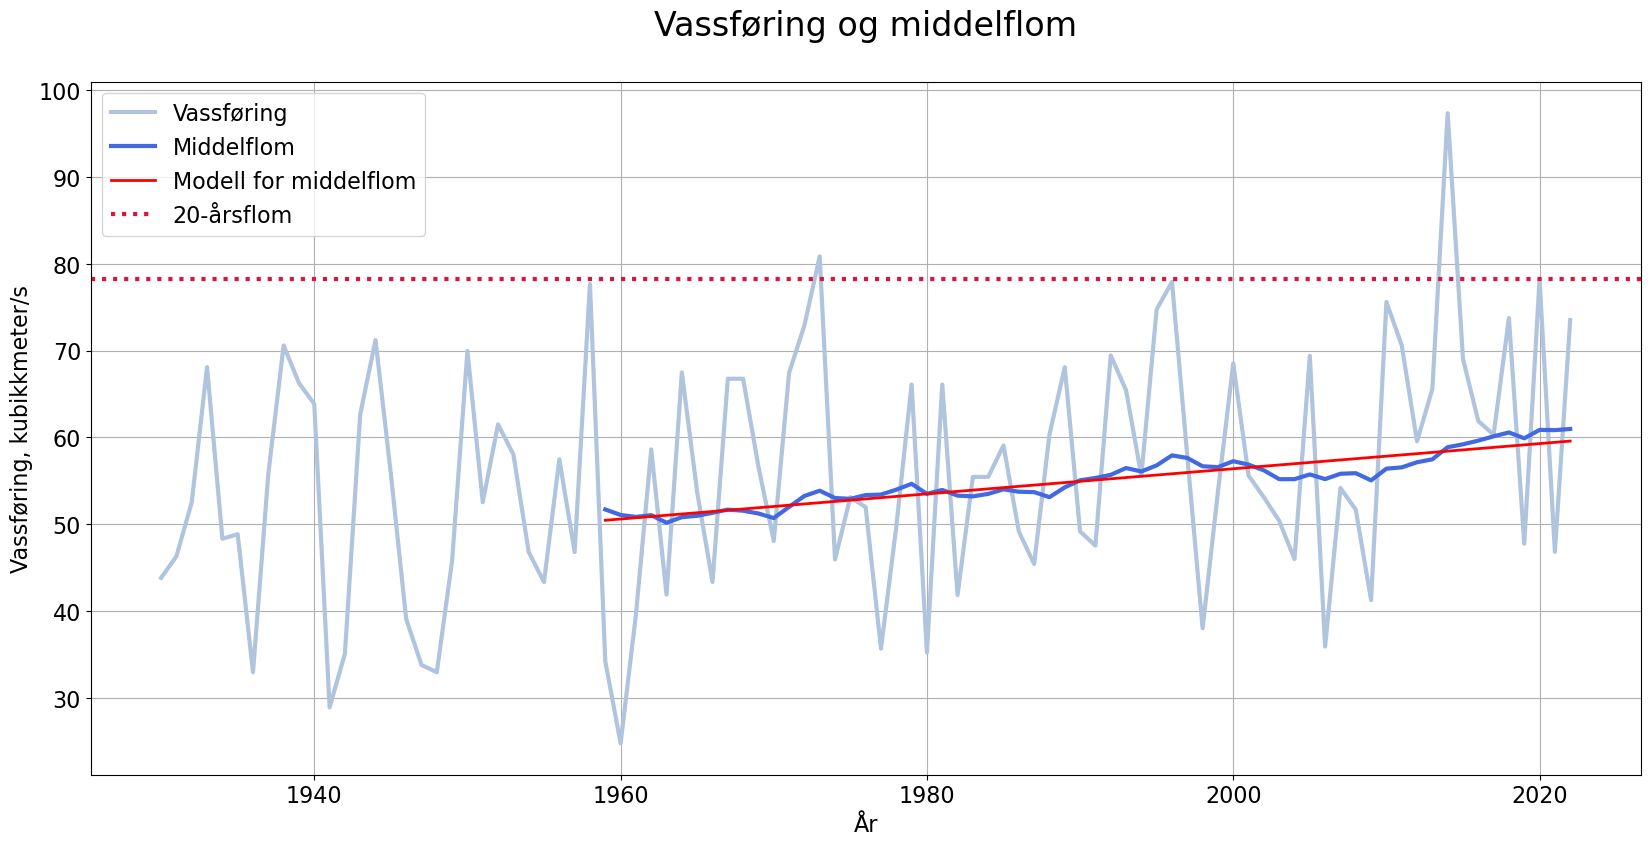

In [34]:
#| code-fold: true
#| fig-align: center
# åra me har data på middelflom
# frå og med 1959 til men ikkje med 2023
x = np.arange(1959, 2023) 

# finn koeffesientane til førstegradspolynomet
a, b = np.polyfit(x, maksvf_og_middelflom["Middelflom"].loc[1959:2022], 1)

# definerer lineær funksjon
def f(x):
    return a*x + b

# plottar dataramma
maksvf_og_middelflom.plot(
    figsize = (20,9), 
    grid = True, 
    fontsize = 16, 
    linewidth = 3, 
    color = ["lightsteelblue", "royalblue"]
)

# plottar modellen
plt.plot(
    x, f(x), 
    linewidth = 2, 
    label = "Modell for middelflom", 
    color = "red"
)

# plottar 20-årsflom
plt.axhline(
        y = 78.28,
        color = "crimson", 
        linewidth = 3, 
        linestyle = ":", 
        label = "20-årsflom"
)

# pynting av plot
plt.title("Vassføring og middelflom\n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
#plt.savefig("Reinsnos - årleg maksvassføring og middelflom.png", dpi = 300)
plt.show()

::: {.callout-tip}
## Tips til oppgåver

Plott linjer for dei ulike flom-typane. Kor godt stemmer observasjonane med desse tala? <br>
Kva ligg i omgrepet 20-årsflom?
:::

# Hydrogram - vassføring per dag

Denne store tabellen vår med daglege data frå over 100 år kan me gjera mykje gøy med. Me kan t.d. sortera alle observasjonane til dag i året, og sjå korleis vassføringa *vanlegvis* er gjennom eit år. I koden under gjer me dette, og i tillegg fargelegg me området mellom 25 og 75-persenilen. På denne måten får me fargelagt dei 50% midterste målingane per dag. Det er òg greitt å visa medianen (som blir hydrogrammet) på figuren. 

Startar med å sortera den opprinnelege `df` til *dag i året* (day of year - `doy`). Etterpå grupperer me materialet i ein ny tabell. 

In [35]:
df['doy'] = df.index.dayofyear
df['år'] = df.index.year
df.head()

,Vassføring,doy,år
1917-06-15,19.06312,166,1917
1917-06-16,16.46433,167,1917
1917-06-17,16.46433,168,1917
1917-06-18,18.67722,169,1917
1917-06-19,21.97948,170,1917


Lagar ein pivottabell med dag i året som rader og årstal som kolonner

In [36]:
piv = pd.pivot_table(df, index=['doy'],columns=['år'], values=['Vassføring'])
piv.head()

Vassføring                                                              \
år        1917      1918      1919      1920      1921      1922      1923   
doy                                                                          
1          NaN  0.751369  0.520992  0.110245  0.520992  2.268141  0.858653   
2          NaN  0.751369  0.481094  0.095431  0.562897  2.268141  0.751369   
3          NaN  0.701046  0.443164  0.095431  0.606849  2.166990  0.803893   
4          NaN  0.701046  0.407161  0.095431  0.652886  1.973261  0.915689   
5          NaN  0.652886  0.373045  0.110245  0.803893  1.703600  0.915689   

                         ...                                           \
år  1924      1925 1929  ...      2014      2015      2016       2017   
doy                      ...                                            
1    NaN  4.303123  NaN  ...  4.858096  1.869427  4.191920  28.483190   
2    NaN  4.003652  NaN  ...  4.406689  3.295648  3.810454  19.011320   
3    NaN  3.858951  NaN  ...  3.952404  4.470398  3.068896  11.995200   
4    NaN  3.717565  NaN  ...  3.694488  4.407481  2.748646   8.526679   
5    NaN  3.444615  NaN  ...  3.422920  4.161712  2.613774   6.329734   

                                                                  
år       2018      2019       2020      2021      2022      2023  
doy                                                               
1    4.161459  2.347107  12.096400  2.466642  4.124214  2.000038  
2    3.759124  2.669421   8.641389  2.288357  5.344579  1.913351  
3    3.438255  2.515568   8.580434  2.122319  6.083396  1.827513  
4    3.053644  2.336836   7.108252  1.954245  5.640584  1.779285  
5    2.739008  2.265773   5.907576  1.806864  4.668677  1.701279  

[5 rows x 104 columns]

## Utrekningar

Finn ulike verdiar per dag i året over dei 104 åra.

In [37]:
piv["min"] = piv.min(axis = 1)
piv["maks"] = piv.max(axis = 1)
piv["75%"] = piv.quantile(q = 0.75,axis = 1)
piv["median"] = piv.median(axis = 1)
piv["25%"] = piv.quantile(q = 0.25,axis = 1)

piv.head()

Vassføring                                                              \
år        1917      1918      1919      1920      1921      1922      1923   
doy                                                                          
1          NaN  0.751369  0.520992  0.110245  0.520992  2.268141  0.858653   
2          NaN  0.751369  0.481094  0.095431  0.562897  2.268141  0.751369   
3          NaN  0.701046  0.443164  0.095431  0.606849  2.166990  0.803893   
4          NaN  0.701046  0.407161  0.095431  0.652886  1.973261  0.915689   
5          NaN  0.652886  0.373045  0.110245  0.803893  1.703600  0.915689   

                         ...                                           \
år  1924      1925 1929  ...      2019       2020      2021      2022   
doy                      ...                                            
1    NaN  4.303123  NaN  ...  2.347107  12.096400  2.466642  4.124214   
2    NaN  4.003652  NaN  ...  2.669421   8.641389  2.288357  5.344579   
3    NaN  3.858951  NaN  ...  2.515568   8.580434  2.122319  6.083396   
4    NaN  3.717565  NaN  ...  2.336836   7.108252  1.954245  5.640584   
5    NaN  3.444615  NaN  ...  2.265773   5.907576  1.806864  4.668677   

                    min      maks       75%    median       25%  
år       2023                                                    
doy                                                              
1    2.000038  0.110245  28.48319  2.589138  1.381706  0.701046  
2    1.913351  0.095431  19.01132  2.548025  1.417153  0.652886  
3    1.827513  0.095431  11.99520  2.491543  1.381060  0.606849  
4    1.779285  0.095431  14.41007  2.421806  1.275205  0.652886  
5    1.701279  0.110245  18.95604  2.372195  1.207931  0.728653  

[5 rows x 109 columns]

## Plottar

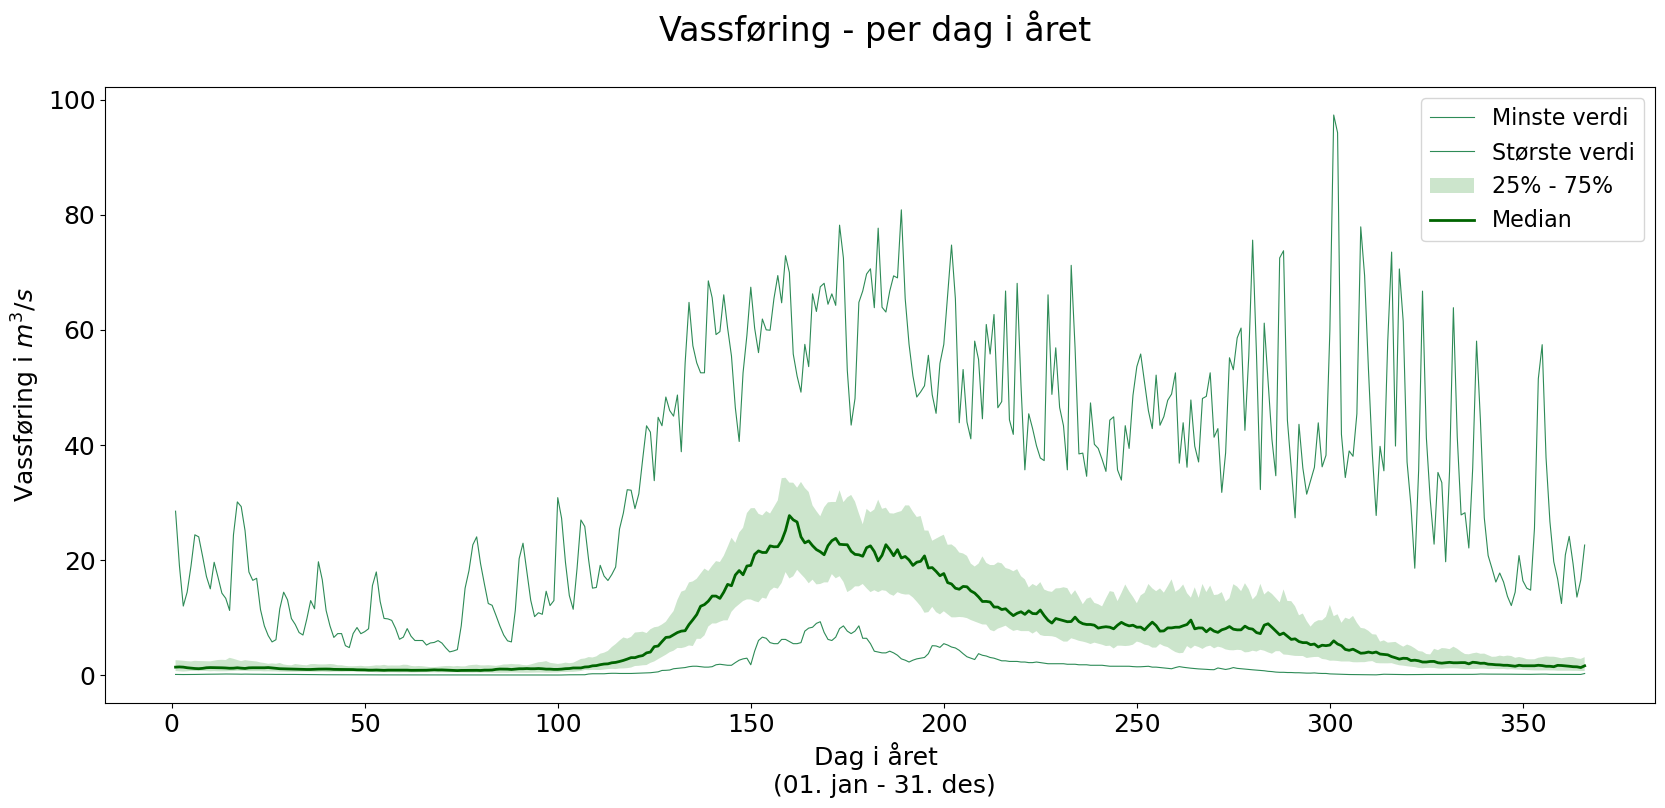

In [38]:
# Plottar minimumsverdiar
piv["min"].plot(
    figsize = (20, 8),
    color = "seagreen", 
    linewidth = 0.8, 
    grid = False, 
    fontsize = 18, 
    legend = False,
    label = "Minste verdi"
)

# PLottar maksimumsverdiar
piv["maks"].plot(
    color = "seagreen", 
    linewidth = 0.8, 
    grid = False, 
    fontsize = 18, 
    legend = False,
    label = "Største verdi"
)

# Fargelegg området mellom 25- og 75-persentilane
plt.fill_between(
    piv.index, 
    piv["25%"], piv["75%"], 
    facecolor='green', 
    alpha=0.2, 
    interpolate=True,
    label = "25% - 75%"
)

# Plottar medianen
piv["median"].plot(
    linewidth = 2, 
    color = "darkgreen",
    label = "Median"
)

# Pyntar på plottet
plt.xlabel("Dag i året \n (01. jan - 31. des)", fontsize = 18)
plt.ylabel("Vassføring i $m^3/s$", fontsize = 18)
plt.title("Vassføring - per dag i året \n", fontsize = 24)
plt.legend(fontsize = 16)
plt.savefig("Reinsnos - vassføring per dag gjennom året.png", dpi = 300)
plt.show()

## Oppsummert

Det er mykje kjekt ein kan gjera med vassføringsdata frå NVE. Både det å laga plott som me har gjort over, og arbeida med store datamengder som dette kan erfaringsmessig gje elevane god innsikt i samanhengar og forståing for omgrep i hydrologien. 

::: {.callout-tip}
## Tips til undervisinga

Dei elevlaga hydrogramma er eit godt utganspunkt for diskusjonar og utforsking.

:one: Jobb med koden saman med elevane. Lag plotta. <br>
:two: Be elevane om å finna andre elver (ulik storleik, ulik geografisk plassering) og lage eigne plott. <br>
:three: Sjå på ulike hydrogram laga av elevane (**utan** namn på vassdraget) og ha diskusjon i klassen om kva informasjon som ligg i plotta (Nord/sør/aust/vest? Høgde? Isbre? Snøsmelting/regnflom? Regulering?) <br>
:four: Avslør namn og plassering - korleis stemte det? 

:::